In [8]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from natsort import natsorted

In [2]:
import os
os.chdir('Jupyter/SiPM/')

In [3]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [5]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [9]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*30V*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for i,File in enumerate(natsorted(D0.Files)[:400]):
    print(i, File)
    print('Getting data...')
    D0.ImportDataFromHDF5(File, D0.Ch)

    print('Getting sampling information...')
    D0.get_sampling()

    print('Getting filtered waveforms...')
    D0.Ch[0].Amp = D0.run_filter(D0.Ch[0].Amp)

    print('Getting deconvolved waveforms...')
    D0.Ch[0].Deconv = D0.run_deconvolution(D0.Ch[0].Amp)

    print('Getting peak amplitudes and positions...')
    D0.get_peaks(D0.Ch[0].Deconv)

    print('Clearing variables...')
    D0.clear()

26
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_0.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting deconvolution filter...
Getting peak amplitudes and positions...
Clearing variables...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_1.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_2.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_3.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved wavef

In [15]:
D0.peak_height = np.array(D0.peak_height)

23.602485107470926


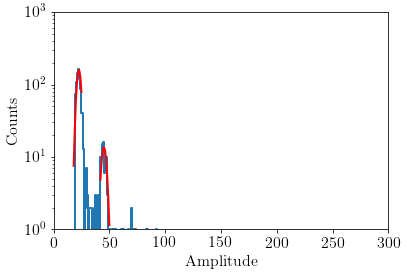

In [92]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

h,hx = np.histogram(D0.peak_height, bins=np.arange(0,300,1))

pe = np.median(D0.peak_height[D0.peak_height>0])
print(pe)
pe_fit = []

plt.figure()
for i in range(1,3):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+1+1*i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10])
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)    

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

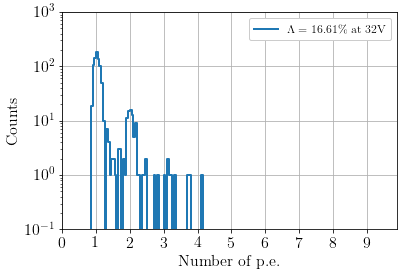

In [93]:
gain = np.diff(pe_fit[:,1])
gain = np.insert(gain,0,pe_fit[0,1])
D0.peak_height_calib = np.array(D0.peak_height)/np.mean(gain)
ca = (np.mean(D0.peak_height_calib[(D0.peak_height_calib<7) & (D0.peak_height_calib>0)]) - 1)*100

h,hx = np.histogram(D0.peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.ylim(1e-1,1e3)
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.2f}$\% at 32V'.format(ca))
plt.legend(loc='upper right')
plt.savefig('deconvolution_hist_pe_calib.pdf')
plt.show()

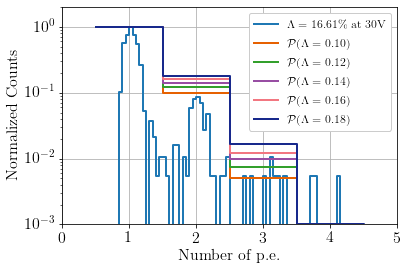

In [94]:
plt.figure()
plt.grid()

plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Normalized Counts')
plt.yscale('log')
plt.step(hx[:-1], h/np.max(h), lw=2, where='post', label='$\Lambda={:.2f}$\% at 30V'.format(ca))

for cav in np.arange(0.1,0.2,0.02):
    hp, hpx = np.histogram(np.random.poisson(lam=cav, size=100000), bins=np.arange(0,10,1))
    plt.step(hpx[:-1]+0.5, hp/np.max(hp), lw=2, where='post', label='$\mathcal{{P}}(\Lambda={:.2f})$'.format(cav))

plt.xlim(0,5)
plt.ylim(1e-3,2e0)
plt.legend(loc='upper right')
plt.savefig('spectrum_poisson_fit.pdf')
plt.show()

In [80]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*31V*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)[:400]):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

    print('Getting sampling information...')
    D1.get_sampling()

    print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

    print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

    print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv, height=30)

    print('Clearing variables...')
    D1.clear()
D1.peak_height = np.array(D1.peak_height)

19
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_0.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting deconvolution filter...
Getting peak amplitudes and positions...
Clearing variables...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_1.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_2.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved waveforms...
Getting peak amplitudes and positions...
Clearing variables...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_3.h5
Getting data...
Getting sampling information...
Getting filtered waveforms...
Getting deconvolved wavef

33.77992597004382


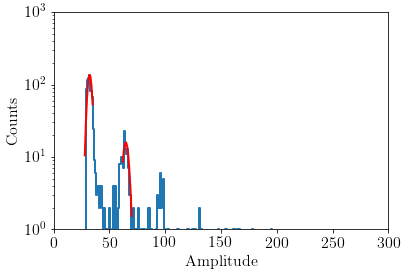

In [95]:
h,hx = np.histogram(D1.peak_height, bins=np.arange(0,300,1))

pe = np.median(D1.peak_height[D1.peak_height>0])
print(pe)
pe_fit = []

plt.figure()
for i in range(1,3):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+1+1*i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10])
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)    

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

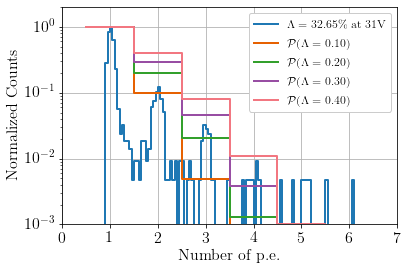

In [97]:
gain = np.diff(pe_fit[:,1])
gain = np.insert(gain,0,pe_fit[0,1])
D1.peak_height_calib = np.array(D1.peak_height)/np.mean(gain)
ca = (np.mean(D1.peak_height_calib[D1.peak_height_calib>0]) - 1)*100
h,hx = np.histogram(D1.peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()

plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Normalized Counts')
plt.yscale('log')
plt.step(hx[:-1], h/np.max(h), lw=2, where='post', label='$\Lambda={:.2f}$\% at 31V'.format(ca))

for cav in np.arange(0.1,0.4,0.1):
    hp, hpx = np.histogram(np.random.poisson(lam=cav, size=100000), bins=np.arange(0,10,1))
    plt.step(hpx[:-1]+0.5, hp/np.max(hp), lw=2, where='post', label='$\mathcal{{P}}(\Lambda={:.2f})$'.format(cav))

plt.xlim(0,7)
plt.ylim(1e-3,2e0)
plt.legend(loc='upper right')
plt.savefig('spectrum_poisson_fit_2.pdf')
plt.show()